In [ ]:
import cv2
import numpy as np
import json
import os
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os

# Config
grid_size = 9 
root_dir = '' 
partition = 'train'

# Load annotations
with open(os.path.join(root_dir, 'annotations.json'), 'r') as f:
    anns = json.load(f)

images = anns['images']
corners_list = anns['annotations']['corners']
split_ids = anns['splits']['chessred2k'][partition]['image_ids']

# Prepare mapping
image_id_to_path = {img['id']: img['path'] for img in images}
corners_by_image = {ann['image_id']: ann['corners'] for ann in corners_list}
image_ids = [img_id for img_id in split_ids]

# Prepare grid ideal points (normalizados 0..1)
xs = np.linspace(0, 1, grid_size)
ys = np.linspace(0, 1, grid_size)
grid_points = np.array([[x, y] for y in ys for x in xs], dtype=np.float32)
grid_points_cv = grid_points.reshape(-1,1,2)

# Prepare list to store pseudo labels
all_grid_labels = []

# Process each image
for img_id in tqdm(image_ids):
    # Load image to get size
    img_path = os.path.join(root_dir, image_id_to_path[img_id])
    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    # Get 4 corners
    c = corners_by_image[img_id]
    src_pts = np.array([
        c['top_left'],
        c['top_right'],
        c['bottom_left'],
        c['bottom_right']
    ], dtype=np.float32)

    # Ideal positions for homography
    dst_pts = np.array([
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1]
    ], dtype=np.float32)

    # Compute homography
    H, _ = cv2.findHomography(dst_pts, src_pts)

    # Project grid
    projected = cv2.perspectiveTransform(grid_points_cv, H)  # shape (N,1,2)
    projected = projected.reshape(-1, 2)

    # Normalize coords to [0,1] by image size
    projected[:,0] /= img_w
    projected[:,1] /= img_h

    # Flatten → [x1,y1,x2,y2,...]
    pseudo_label = projected.flatten()
    all_grid_labels.append(pseudo_label)

# Save as npy
all_grid_labels = np.stack(all_grid_labels)
os.makedirs("grid_labels", exist_ok=True)
np.save(f"grid_labels/{partition}_grid_labels.npy", all_grid_labels)

print(f"✅ Saved grid_labels/{partition}_grid_labels.npy → shape {all_grid_labels.shape}")


  9%|▉         | 136/1442 [00:07<01:11, 18.27it/s]


KeyboardInterrupt: 

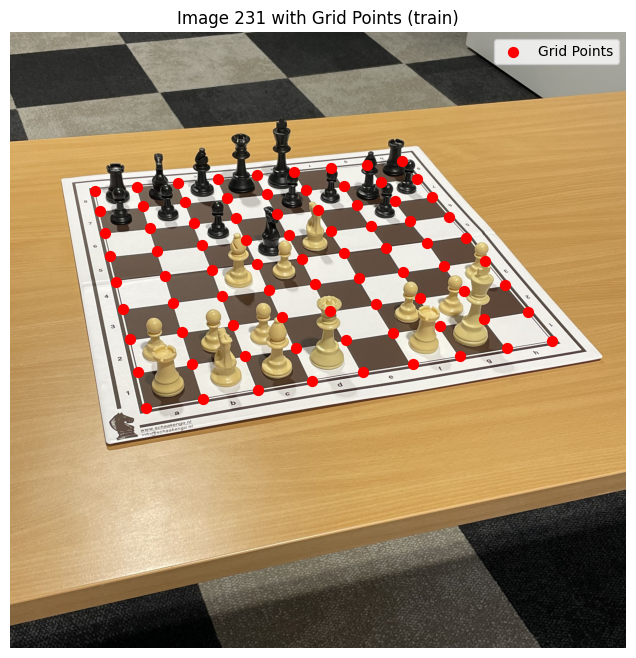

In [ ]:
root_dir = ''
partition = 'train'
idx = 231

with open(os.path.join(root_dir, 'annotations.json'), 'r') as f:
    anns = json.load(f)

images = anns['images']
split_ids = anns['splits']['chessred2k'][partition]['image_ids']
image_id_to_path = {img['id']: img['path'] for img in images}
image_ids = [img_id for img_id in split_ids]

grid_labels = np.load(f"grid_labels/{partition}_grid_labels.npy")

img_id = image_ids[idx]
img_path = os.path.join(root_dir, image_id_to_path[img_id])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_h, img_w = img.shape[:2]

grid_points_norm = grid_labels[idx].reshape(-1, 2)

grid_points_px = grid_points_norm.copy()
grid_points_px[:,0] *= img_w
grid_points_px[:,1] *= img_h

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.scatter(grid_points_px[:,0], grid_points_px[:,1], color='red', s=50, label='Grid Points')
plt.title(f"Image {idx} with Grid Points ({partition})")
plt.legend()
plt.axis('off')
plt.show()
